In [ ]:
pip install hmmlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
from datetime import datetime
from scipy import stats
from plotly.subplots import make_subplots
np.random.seed(42)


# 1. Hidden Markov Model (HMM)



## 1.1 Objectifs:




- Comprendre ce qu'est une Chaine de Markov et une Chaine Cachée de Markov HMM.
- Construire un exemple de HMM jouet.
- Implémenter :
  - la simulation d'une séquence d'états/observations,
  - l'algorithme **Forward** (mise à jour de croyances),
  - l'algorithme **Viterbi** (chemin le plus probable des états cachés).
- Faire le lien avec un cas simple de **régimes de marché** (Bull / Bear).

## 1.2 Chaîne de Markov



On se donne deux **états visibles**:

- État 0 = “Bull”
- État 1 = “Bear”

On se déplace entre ces états, avec des **probabilités de transition** :

- si on est dans l'état 0 aujourd'hui, on a 90% de rester, 10% d'aller à l'état 1.
- si on est dans l'état 1 aujourd'hui, on a 80% de rester, 20% de revenir à l'état 0.

Ce système où **le futur dépend seulement de l'état actuel**  
(et pas du passé complet) s'appelle une **chaîne de Markov**.

On va :

1. simuler un trajet de 1000 jours entre ces 2 états,
2. tracer la séquence pour la visualiser,
3. regarder la fréquence de chaque état.


In [ ]:
def simulate_markov_chain(T, pi, A):
    """
    ---- Obj :--------------------------------
    Simuler une chaîne de Markov de longueur T.
    -----Paramètres: --------------------------
    T : int - Longueur de la séquence.
    pi : array de shape (N,) - Distribution initiale.
    A : array de shape (N, N) - Matrice de transition.
    -----Retour--------------------------------
    states : array de shape (T,)
        Séquence d'états simulée.
    """
    N = len(pi)
    states = np.zeros(T, dtype=int)
    # état initial
    states[0] = np.random.choice(N, p=pi)
    # transitions
    for t in range(1, T):
        states[t] = np.random.choice(N, p=A[states[t-1]])
    return states

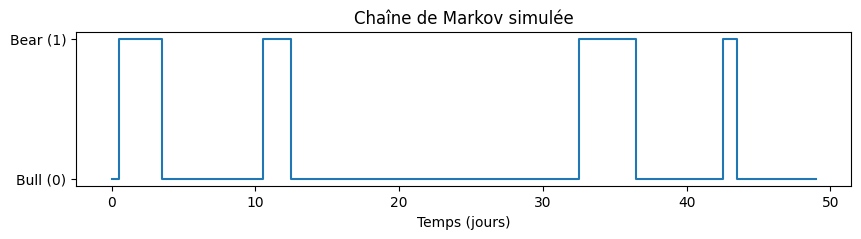

In [ ]:

state_names = ["Bull", "Bear"]
pi = np.array([0.5, 0.5])  # Au début, 50% de chances d'être dans l'état 0 ou 1
A = np.array([[0.9, 0.1],  # Ligne 0 : si je suis en 0 -> 90% rester, 10% aller à 1
              [0.3, 0.7]]) # Ligne 1 : si je suis en 1 -> 30% aller à 0, 70% rester

T = 50
states = simulate_markov_chain(T, pi, A)

plt.figure(figsize=(10, 2))
plt.plot(states, drawstyle="steps-mid")
plt.yticks([0, 1], ["Bull (0)", "Bear (1)"])
plt.title("Chaîne de Markov simulée")
plt.xlabel("Temps (jours)")
plt.show()


## 1.3 Modèle de Markov Caché



On garde l'idée d'un **état** qui évolue selon une chaîne de Markov. Mais **on ne voit plus l'état directement**.  
À la place, on observe une **variable** qui dépend de cet état.

Exemple :

- L'**état caché** : le régime de marché  (Bull / Bear).
- Ce qu’on **observe** : est-ce que le rendement du marché est positif ou pas ?

On va supposer :

- Si le régime est **Bull** :
  - 20% de chances que le rendement soit négatif
  - 80% de chances que le rendement soit positif

- Si le régime est **Bear** :
  - 90% de chances que le rendement soit négatif
  - 10% de chances que le rendement soit positif

La situation devient :

- On **ne voit plus** le régime (Bull/Bear),
- On **voit seulement** une suite : Rendement marché positif / Rendement marché négatif,
- Et on voudrait **deviner** le régime à partir de cette suite.

> les états sont cachés, les observations sont visibles.

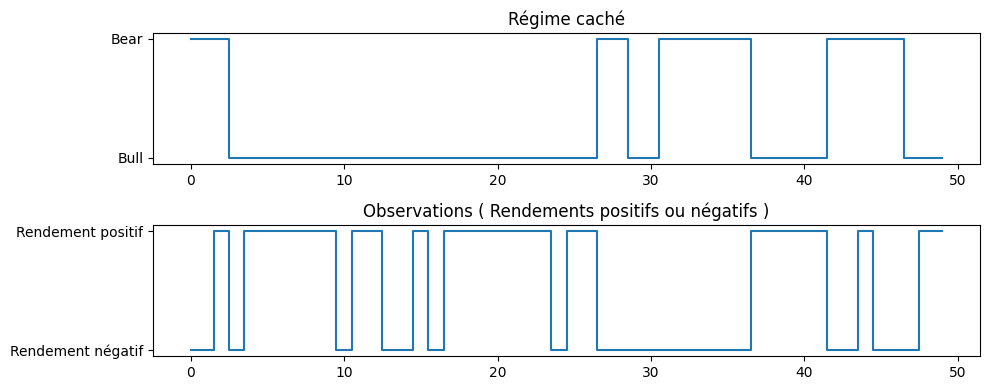

In [ ]:
# Probabilités d'émission
# observation : 0 = Rendement négatif , 1 = Rendement positif
obs_names   = ["Rendement négatif", "Rendement positif"]
B = np.array([
    [0.2, 0.8],  # Si Bull -> (Rendement négatif, Rendement positif)
    [0.9, 0.1],  # Si Bear  -> (Rendement négatif, Rendement positif)
])

hidden_states = np.zeros(T, dtype=int)    # Régime (cachée)
observations  = np.zeros(T, dtype=int)    # Rendement observé
pi = np.array([0.5, 0.5])  # Au début

# Jour 0
hidden_states[0] = np.random.choice([0, 1], p=pi)
observations[0]  = np.random.choice([0, 1], p=B[hidden_states[0]])

# Jours suivants
for t in range(1, T):
    hidden_states[t] = np.random.choice([0, 1], p=A[hidden_states[t-1]])
    observations[t]  = np.random.choice([0, 1], p=B[hidden_states[t]])

plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.step(range(T), hidden_states, where="mid")
plt.yticks([0, 1], ["Bull", "Bear"])
plt.title("Régime caché")

plt.subplot(2, 1, 2)
plt.step(range(T), observations, where="mid")
plt.yticks([0, 1], ["Rendement négatif", "Rendement positif"])
plt.title("Observations ( Rendements positifs ou négatifs )")

plt.tight_layout()
plt.show()


## 1.4 Algorithmes clés



### Algorithme Forward (filtrage)


Chaque jour, on reçoit une nouvelle observation sur le rendement. On aimerait mettre à jour nos **croyances** :

1. On part de nos croyances d'hier : "Hier, je pensais que Bull = 60%, Bear = 40%."

2. On voit comment ces croyances se projettent sur aujourd'hui
   avec la **matrice de transition** (Bull/Bear -> Bull/Bear).

3. Ensuite, on regarde l'observation d'aujourd'hui :
   - Si on voit un rendement positif, ça favorise l'état "Bull".
   - Si on voit un rendement négatif, ça favorise "Bear".

4. On combine le tout et on renormalise pour obtenir : "Aujourd'hui, ma nouvelle croyance est : Bull X%, Bear Y%."

> L'algorithme forward sert à mettre à jour des croyances sur les états cachés,
> au fil des observations.

In [ ]:
def forward(obs, A, B, pi):

    T = len(obs)
    N = len(pi)
    prior = np.zeros((T, N))
    post  = np.zeros((T, N))

    # t = 0 : avant d'observer le jour 0, notre croyance est pi
    prior[0] = pi
    # après observation du jour 0
    post[0] = prior[0] * B[:, obs[0]]
    post[0] /= post[0].sum()

    for t in range(1, T):
        # 1) projection des croyances d'hier vers aujourd'hui (AVANT obs[t])
        prior[t] = post[t-1] @ A
        # 2) mise à jour AVEC obs[t]
        post[t] = prior[t] * B[:, obs[t]]
        post[t] /= post[t].sum()

    return prior, post



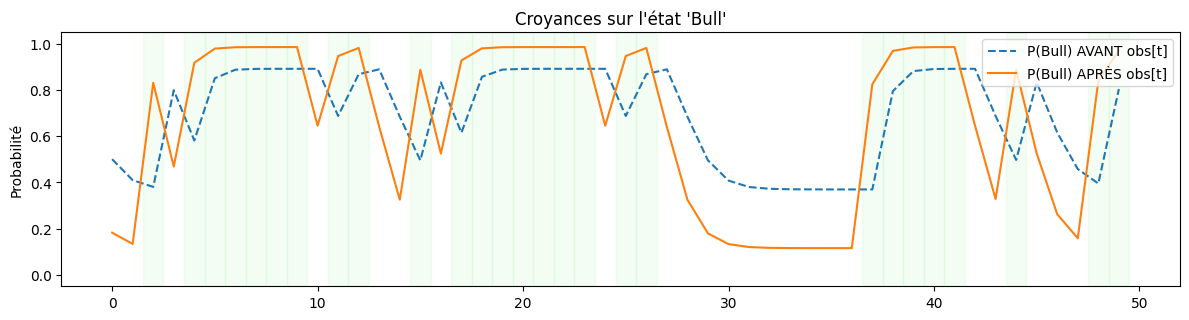

In [ ]:
prior, post = forward(observations, A, B, pi)

plt.figure(figsize=(12, 6))

# --- P(Bull) ---
plt.subplot(2, 1, 1)
plt.plot(prior[:, 0],  linestyle="--", label="P(Bull) AVANT obs[t]")
plt.plot(post[:, 0],   linestyle="-",  label="P(Bull) APRÈS obs[t]")
plt.ylim(-0.05, 1.05)
plt.ylabel("Probabilité")
plt.title("Croyances sur l'état 'Bull'")


for t in range(T):
    if observations[t] == 1:
        plt.axvspan(t-0.5, t+0.5, color="lightgreen", alpha=0.1)

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



L’algorithme **Forward** calcule, pour chaque date `t` et chaque régime `j` :

- la probabilité d’être dans le régime `j` compte tenu des observations :

- `P(S_t = Bull | Obeservations)`
- `P(S_t = Bear | Obeservations)`

À partir de ces probabilités et d'un seuil, on peut définir un régime “instantané” (posterior decoding) :

- Bull si `P(Bull) > 0.7`
- Bear si `P(Bear) > 0.7`
- zone neutre si aucune proba n’est franchement dominante

In [ ]:
threshold = 0.6
T = post.shape[0]
t = np.arange(T)

# 0 = Bull, 1 = Bear, -1 = Incertain
regime_thresh = np.full(T, -1, dtype=int)

for i in range(T):
    p_bull = post[i, 0]
    p_bear  = post[i, 1]

    if p_bull > threshold:
        regime_thresh[i] = 0
    elif p_bear > threshold:
        regime_thresh[i] = 1
    else:
        regime_thresh[i] = -1

Pourcentages :
Bull: 64.0 %
Bear: 30.0 %
Incertain: 6.0 %


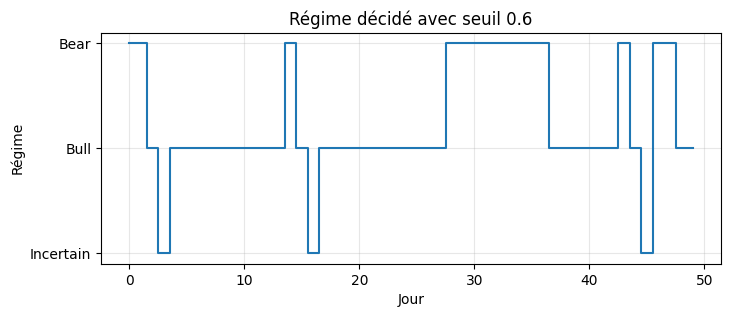

In [ ]:
n_total = len(regime_thresh)

n_bull   = np.sum(regime_thresh == 0)
n_bear     = np.sum(regime_thresh == 1)
n_incertain = np.sum(regime_thresh == -1)

percent_bull    = 100 * n_bull / n_total
percent_bear   = 100 * n_bear / n_total
percent_incertain = 100 * n_incertain / n_total

labels = ["Bull", "Bear", "Incertain"]
percents = [percent_bull, percent_bear, percent_incertain]

print("Pourcentages :")
for lab, p in zip(labels, percents):
    print(f"{lab}: {p:.1f} %")
plt.figure(figsize=(8, 3))
plt.step(t, regime_thresh, where="mid")
plt.yticks(
    [-1, 0, 1],
    ["Incertain", "Bull", "Bear"]
)
plt.xlabel("Jour")
plt.ylabel("Régime")
plt.title(f"Régime décidé avec seuil {threshold}")
plt.grid(True, alpha=0.3)
plt.show()


### Algorithme Viterbi (décodage)




L’algorithme de **Viterbi** cherche **le chemin complet de régimes le plus probable** sur toute la période.

> Parmi tous les chemins possibles  
> `(Etat_0, Etat_1, ..., Etat_T)`  
> Viterbi choisit celui qui maximise la probabilité d’avoir vu ces états.

Par exemple

- `Etat_hat = [Bull, Bear, Bear, Bull ...... Bear]`

- On obtient une **histoire cohérente** des régimes dans le temps.
- L’algorithme tient compte :
  - de la probabilité des états sous chaque régime,
  - **et** de la matrice de transition (persistance des régimes).
- Cet algorithme nous permet de :
  - **labelliser** les périodes,
  - calculer des statistiques par régime

#### L'algo step by step

In [ ]:
obs = [0, 1, 1] # séquence observée à titre d'exemple
print("Matrice de transition :" )
print(A)
print("Matrice d'emission' :" )
print(B)
print("Proba intiales' :" )
print(pi)
print("Régimes' :" )
print(state_names)

Matrice de transition :
[[0.9 0.1]
 [0.3 0.7]]
Matrice d'emission' :
[[0.2 0.8]
 [0.9 0.1]]
Proba intiales' :
[0.5 0.5]
Régimes' :
['Bull', 'Bear']


In [ ]:
print("=== Étape 1 : Initialisation (t = 0) ===")

# Proba d'être en Bull à t=0 ET d'observer obs[0]
p_bull_0 = pi[0] * B[0, obs[0]]
# Proba d'être en Bear à t=0 ET d'observer obs[0]
p_bear_0 = pi[1] * B[1, obs[0]]

print(f"t=0, état Bull : pi(Bull) * B(Bull -> obs0={obs[0]}) = "
      f"{pi[0]:.2f} * {B[0, obs[0]]:.2f} = {p_bull_0:.4f}")
print(f"t=0, état Bear : pi(Bear) * B(Bear -> obs0={obs[0]}) = "
      f"{pi[1]:.2f} * {B[1, obs[0]]:.2f} = {p_bear_0:.4f}")


=== Étape 1 : Initialisation (t = 0) ===
t=0, état Bull : pi(Bull) * B(Bull -> obs0=0) = 0.50 * 0.20 = 0.1000
t=0, état Bear : pi(Bear) * B(Bear -> obs0=0) = 0.50 * 0.90 = 0.4500


In [ ]:
print("\n=== Étape 2 : t = 1, observation obs[1] =", obs[1], "===\n")

# --------- Arriver en Bull à t=1 ---------
# Cas 1 : Bull -> Bull
p_bull1_from_bull0 = p_bull_0 * A[0, 0] * B[0, obs[1]]
print(f"Chemin Bull -> Bull : {p_bull_0:.4f} * {A[0,0]:.2f} * {B[0, obs[1]]:.2f} "
      f"= {p_bull1_from_bull0:.4f}")

# Cas 2 : Bear -> Bull
p_bull1_from_bear0 = p_bear_0 * A[1, 0] * B[0, obs[1]]
print(f"Chemin Bear -> Bull : {p_bear_0:.4f} * {A[1,0]:.2f} * {B[0, obs[1]]:.2f} "
      f"= {p_bull1_from_bear0:.4f}")

# On garde le meilleur des deux
if p_bull1_from_bull0 >= p_bull1_from_bear0:
    p_bull_1 = p_bull1_from_bull0
    prev_bull_1 = "Bull"
else:
    p_bull_1 = p_bull1_from_bear0
    prev_bull_1 = "Bear"

print(f"=> Meilleur chemin pour finir en Bull à t=1 : vient de {prev_bull_1} "
      f"avec proba {p_bull_1:.4f}\n")

# --------- Arriver en Bear à t=1 ---------
# Cas 1 : Bull -> Bear
p_bear1_from_bull0 = p_bull_0 * A[0, 1] * B[1, obs[1]]
print(f"Chemin Bull -> Bear : {p_bull_0:.4f} * {A[0,1]:.2f} * {B[1, obs[1]]:.2f} "
      f"= {p_bear1_from_bull0:.4f}")

# Cas 2 : Bear -> Bear
p_bear1_from_bear0 = p_bear_0 * A[1, 1] * B[1, obs[1]]
print(f"Chemin Bear -> Bear : {p_bear_0:.4f} * {A[1,1]:.2f} * {B[1, obs[1]]:.2f} "
      f"= {p_bear1_from_bear0:.4f}")

# On garde le meilleur des deux
if p_bear1_from_bull0 >= p_bear1_from_bear0:
    p_bear_1 = p_bear1_from_bull0
    prev_bear_1 = "Bull"
else:
    p_bear_1 = p_bear1_from_bear0
    prev_bear_1 = "Bear"

print(f"=> Meilleur chemin pour finir en Bear à t=1 : vient de {prev_bear_1} "
      f"avec proba {p_bear_1:.4f}")



=== Étape 2 : t = 1, observation obs[1] = 1 ===

Chemin Bull -> Bull : 0.1000 * 0.90 * 0.80 = 0.0720
Chemin Bear -> Bull : 0.4500 * 0.30 * 0.80 = 0.1080
=> Meilleur chemin pour finir en Bull à t=1 : vient de Bear avec proba 0.1080

Chemin Bull -> Bear : 0.1000 * 0.10 * 0.10 = 0.0010
Chemin Bear -> Bear : 0.4500 * 0.70 * 0.10 = 0.0315
=> Meilleur chemin pour finir en Bear à t=1 : vient de Bear avec proba 0.0315


In [ ]:
print("\n=== Étape 3 : t = 2, observation obs[2] =", obs[2], "===\n")

# --------- Arriver en Bull à t=2 ---------
# Cas 1 : Bull(t=1) -> Bull(t=2)
p_bull2_from_bull1 = p_bull_1 * A[0, 0] * B[0, obs[2]]
print(f"Chemin (meilleur Bull à t=1) -> Bull : {p_bull_1:.4f} * {A[0,0]:.2f} * {B[0, obs[2]]:.2f} "
      f"= {p_bull2_from_bull1:.4f}")

# Cas 2 : Bear(t=1) -> Bull(t=2)
p_bull2_from_bear1 = p_bear_1 * A[1, 0] * B[0, obs[2]]
print(f"Chemin (meilleur Bear à t=1) -> Bull : {p_bear_1:.4f} * {A[1,0]:.2f} * {B[0, obs[2]]:.2f} "
      f"= {p_bull2_from_bear1:.4f}")

if p_bull2_from_bull1 >= p_bull2_from_bear1:
    p_bull_2 = p_bull2_from_bull1
    prev_bull_2 = "Bull"
else:
    p_bull_2 = p_bull2_from_bear1
    prev_bull_2 = "Bear"

print(f"=> Meilleur chemin pour finir en Bull à t=2 : vient de {prev_bull_2} "
      f"avec proba {p_bull_2:.4f}\n")

# --------- Arriver en Bear à t=2 ---------
# Cas 1 : Bull(t=1) -> Bear(t=2)
p_bear2_from_bull1 = p_bull_1 * A[0, 1] * B[1, obs[2]]
print(f"Chemin (meilleur Bull à t=1) -> Bear : {p_bull_1:.4f} * {A[0,1]:.2f} * {B[1, obs[2]]:.2f} "
      f"= {p_bear2_from_bull1:.4f}")

# Cas 2 : Bear(t=1) -> Bear(t=2)
p_bear2_from_bear1 = p_bear_1 * A[1, 1] * B[1, obs[2]]
print(f"Chemin (meilleur Bear à t=1) -> Bear : {p_bear_1:.4f} * {A[1,1]:.2f} * {B[1, obs[2]]:.2f} "
      f"= {p_bear2_from_bear1:.4f}")

if p_bear2_from_bull1 >= p_bear2_from_bear1:
    p_bear_2 = p_bear2_from_bull1
    prev_bear_2 = "Bull"
else:
    p_bear_2 = p_bear2_from_bear1
    prev_bear_2 = "Bear"

print(f"=> Meilleur chemin pour finir en Bear à t=2 : vient de {prev_bear_2} "
      f"avec proba {p_bear_2:.4f}")



=== Étape 3 : t = 2, observation obs[2] = 1 ===

Chemin (meilleur Bull à t=1) -> Bull : 0.1080 * 0.90 * 0.80 = 0.0778
Chemin (meilleur Bear à t=1) -> Bull : 0.0315 * 0.30 * 0.80 = 0.0076
=> Meilleur chemin pour finir en Bull à t=2 : vient de Bull avec proba 0.0778

Chemin (meilleur Bull à t=1) -> Bear : 0.1080 * 0.10 * 0.10 = 0.0011
Chemin (meilleur Bear à t=1) -> Bear : 0.0315 * 0.70 * 0.10 = 0.0022
=> Meilleur chemin pour finir en Bear à t=2 : vient de Bear avec proba 0.0022


In [ ]:
print("\n=== Étape 4 : Choix du dernier état et backtracking ===")

# Quel état est le plus probable à t=2 ?
if p_bull_2 >= p_bear_2:
    last_state = "Bull"
else:
    last_state = "Bear"

print(f"À t=2, l'état le plus probable est : {last_state}")

# Backtracking :
# t=2 -> last_state
# t=1 -> on regarde d'où venait cet état à t=2
# t=0 -> on regarde d'où venait l'état de t=1

if last_state == "Bull":
    state_t2 = "Bull"
    state_t1 = prev_bull_2
else:
    state_t2 = "Bear"
    state_t1 = prev_bear_2

# remonter à t=0
if state_t1 == "Bull":
    state_t0 = prev_bull_1
else:
    state_t0 = prev_bear_1

print(f"Séquence la plus probable : t=0: {state_t0} -> t=1: {state_t1} -> t=2: {state_t2}")



=== Étape 4 : Choix du dernier état et backtracking ===
À t=2, l'état le plus probable est : Bull
Séquence la plus probable : t=0: Bear -> t=1: Bull -> t=2: Bull


#### Construction de l'algorithme

In [ ]:
def viterbi_discrete(obs, A, B, pi):

    T = len(obs)
    N = len(pi)

    delta = np.zeros((T, N))
    psi   = np.zeros((T, N), dtype=int)

    # Initialisation
    delta[0] = np.log(pi) + np.log(B[:, obs[0]])
    psi[0] = 0

    # Récurrence
    for t in range(1, T):
        for j in range(N):
            candidates = delta[t-1] + np.log(A[:, j])
            psi[t, j] = np.argmax(candidates)
            delta[t, j] = np.max(candidates) + np.log(B[j, obs[t]])

    # Backtracking
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        path[t] = psi[t+1, path[t+1]]

    return path


In [ ]:
viterbi_path = viterbi_discrete(observations, A, B, pi)
accuracy = np.mean(viterbi_path == hidden_states)

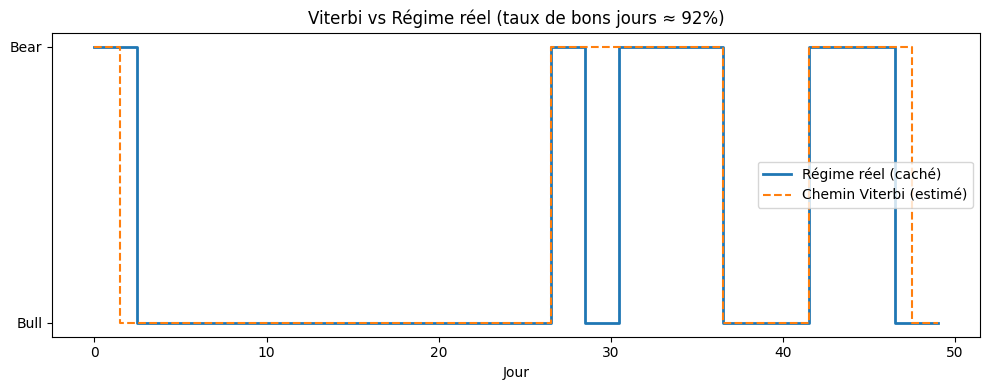

In [ ]:
#Plot
plt.figure(figsize=(10, 4))

plt.step(range(len(hidden_states)), hidden_states, where="mid",
         label="Régime réel (caché)", linewidth=2)
plt.step(range(len(viterbi_path)), viterbi_path, where="mid",
         label="Chemin Viterbi (estimé)", linestyle="--")
plt.yticks([0, 1], ["Bull", "Bear"])
plt.xlabel("Jour")
plt.title(f"Viterbi vs Régime réel (taux de bons jours ≈ {accuracy:.0%})")
plt.legend()
plt.tight_layout()
plt.show()


- La **ligne pleine** montre le régime réel (Bull/Bear) jour par jour.  
  → En pratique, on ne la connaît jamais : c'est ce qu'on essaie de deviner.

- La **ligne en pointillé** montre le **chemin Viterbi** :
  > la séquence d'états (Bull/Bear) la plus probable,
  > compte tenu de toute la série d'observations.




### Forward vs Viterbi

Forward sert à prendre des décisions en temps réel avec des probabilités :

“Aujourd’hui, proba bull = 80%, donc j’augmente mon exposition.”

Viterbi sert à raconter et exploiter l’histoire complète :

“Sur les 10 dernières années, voici comment je pense que les régimes se sont enchaînés,
et voilà les stats/strats associées à chaque phase.”

Les deux sont complémentaires :

- On utilise Forward pour les signaux live (filtrage en t).

- On utilise Viterbi pour analyser le passé et faire des stats par régime.


# 1. Application sur les marchés financiers




### 1. Application sur les marchés financiers

- **États cachés :**
  - **Régime 0 = Bull** : marché calme, volatilité faible, tendance plutôt haussière.
  - **Régime 1 = Bear** : marché stressé, volatilité forte, tendance plutôt baissière.

- **Observations :**
  - les **rendements journaliers** d’un indice.

- **Dynamique de type Markov :**
  
  Si le marché est en **Bull** aujourd’hui, il a une forte probabilité d’être encore en Bull demain,  
  mais il existe toujours une certaine probabilité de basculer en **Bear** (phase de crise), et inversement.

- **Signature statistique de chaque régime sur les rendements :**
  - en **Bull** : volatilité faible, moyenne des rendements \(> 0\),
  - en **Bear** : volatilité élevée, moyenne des rendements \(< 0\).

À partir des rendements observés, le HMM tente de **reconstituer la séquence de régimes cachés** (Bull / Bear) :
il infère dans quel régime nous nous trouvons à chaque date et comment les régimes se sont enchaînés dans le temps.



Avec `hmmlearn`, on fait en général l'inverse de ce qu'on a fait avant :

- Avant : on connaissait les paramètres (π, A, μ, σ) → on calculait les états.
- Maintenant : on **ne connaît que les données** (les rendements)  
  → le HMM va **estimer les paramètres** ET les états cachés.

La librairie fournit :

- un objet `GaussianHMM` (émissions continues, adapté aux rendements) ;
- une méthode `.fit()` :
  - qui estime π, A, μ, σ à partir des données avec l'algorithme EM (Baum–Welch),
  - EM = itérations entre :
    - E-step : utilise Forward-Backward pour calculer des probabilités d'états,
    - M-step : met à jour π, A, μ, σ pour mieux coller aux données.
- une méthode `.predict()` :
  - qui renvoie le **chemin d'états cachés** le plus probable **Viterbi**.
- une méthode `.predict_proba()` :
  - qui renvoie les **probabilités P(S_t = j | données)**, l'équivalent des **croyances** (sortie du Forward).

## 1. Data

### 1.1. Données et log-rendements


In [ ]:
ticker = "SPY"
start_date = "2000-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

In [ ]:
data = yf.download(ticker, start=start_date, end=end_date)
data = data[["Close"]].dropna()
data.rename(columns={"Close": "price"}, inplace=True)

data["log_ret"] = np.log(data["price"] / data["price"].shift(1))
data.dropna(inplace=True)

data.head()

/tmp/ipython-input-3007726117.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,price,log_ret
Ticker,SPY,
Date,,
2000-01-04,88.034294,-0.039891
2000-01-05,88.191750,0.001787
2000-01-06,86.774376,-0.016202
2000-01-07,91.813904,0.056452
2000-01-10,92.128891,0.003425


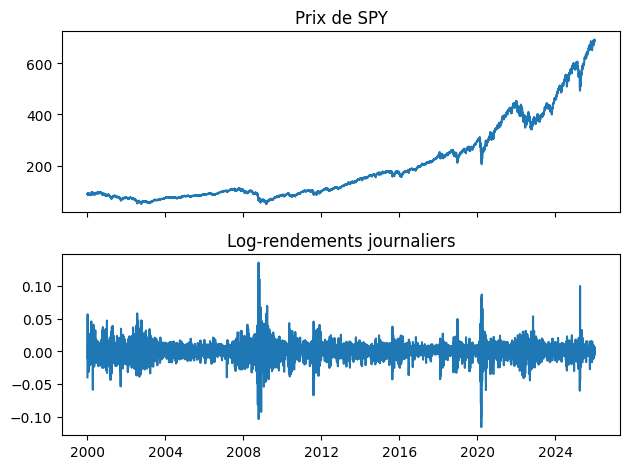

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(data.index, data["price"])
axs[0].set_title(f"Prix de {ticker}")

axs[1].plot(data.index, data["log_ret"])
axs[1].set_title("Log-rendements journaliers")

plt.tight_layout()
plt.show()

### 1.2 Normalité des log-rendements


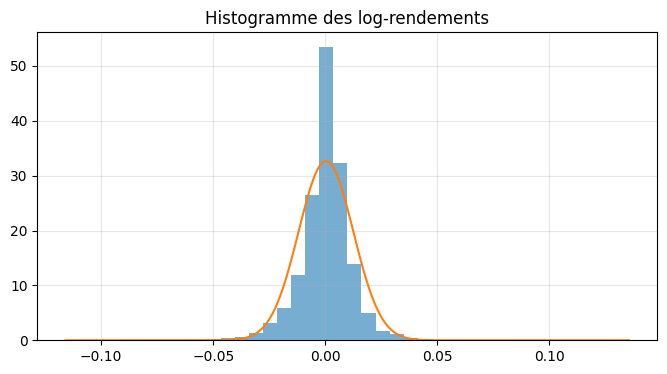

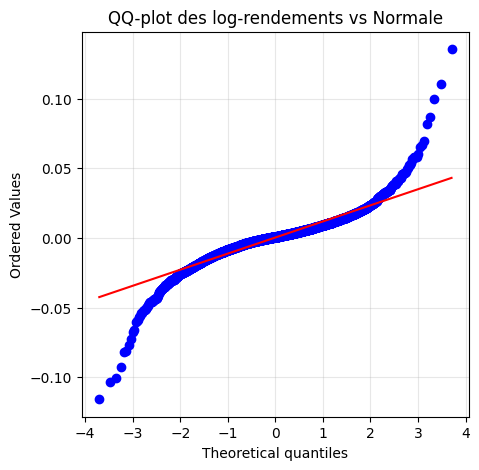

Jarque-Bera stat=36303.52, p-value=0.0000


In [ ]:
r = data["log_ret"].values
# 1) Histogramme
plt.figure(figsize=(8,4))
plt.hist(r, bins=40, density=True, alpha=0.6)
mu, sigma = r.mean(), r.std()
x = np.linspace(r.min(), r.max(), 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title("Histogramme des log-rendements")
plt.grid(True, alpha=0.3)
plt.show()

# 2) QQ-plot
plt.figure(figsize=(5,5))
stats.probplot(r, dist="norm", plot=plt)
plt.title("QQ-plot des log-rendements vs Normale")
plt.grid(True, alpha=0.3)
plt.show()

# 3) Test de Jarque-Bera
jb_stat, jb_p = stats.jarque_bera(r)
print(f"Jarque-Bera stat={jb_stat:.2f}, p-value={jb_p:.4f}")

Le test de **Jarque-Bera**:

$
JB \approx 36082,\quad p\text{-value} \approx 0.0000
$

conduit à rejeter très clairement l’hypothèse de normalité inconditionnelle des
log-rendements.

Point important pour le HMM :

- le HMM gaussien **n’impose pas** que la distribution inconditionnelle des rendements
  soit normale ;
- il suppose que, **conditionnellement au régime** $(S_t = s)$, on a :
  $
  r_t \mid S_t=s \sim \mathcal{N}(\mu_s, \sigma_s^2).
  $
- la distribution inconditionnelle est alors un **mélange de gaussiennes**,
  ce qui permet justement de mieux capturer les queues épaisses observées.

Donc : le rejet de la normalité simple ne remet pas en cause le HMM, au contraire,
il motive l’utilisation d’un **mélange de régimes gaussiens** plutôt qu’une seule
gaussienne.


### 1.3. Dépendance temporelle des rendements


<Figure size 600x300 with 0 Axes>

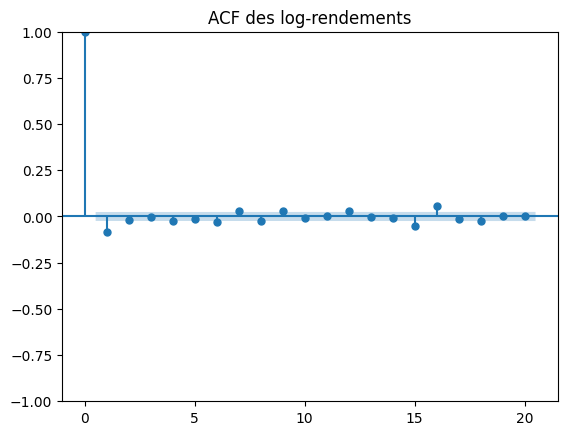

      lb_stat     lb_pvalue
10  77.634481  1.457662e-12


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.figure(figsize=(6,3))
plot_acf(r, lags=20)
plt.title("ACF des log-rendements")
plt.show()

lb = acorr_ljungbox(r, lags=[10], return_df=True)
print(lb)


L’ACF des log-rendements montre des autocorrélations très proches de zéro à
tous les lags, ce qui est cohérent avec l’idée de **faible prévisibilité linéaire**.

Cependant, le test de **Ljung–Box** au lag 10 donne :

- statistique $LB \approx 77.5\,
-  p-value \approx 1.6 \times 10^{-12}$,

ce qui conduit à rejeter l’hypothèse “pas d’autocorrélation” au sens strictement
statistique. En pratique, les autocorrélations sont très petites mais détectables
sur un échantillon aussi long.

Dans le cadre du HMM :

- le modèle suppose que **conditionnellement au régime**, les rendements sont
  indépendants dans le temps ;
- il n’interdit pas une **dépendance inconditionnelle** induite par la dynamique
  de régimes (le fait que les régimes persistent crée de la structure dans les
  données, en particulier sur la volatilité).

Ce résultat est donc compatible avec l’idée d’un processus “presque i.i.d.”
en rendements, mais avec une structure cachée à capturer via les régimes.


### 1.4. Volatilité roulante : mise en évidence des régimes


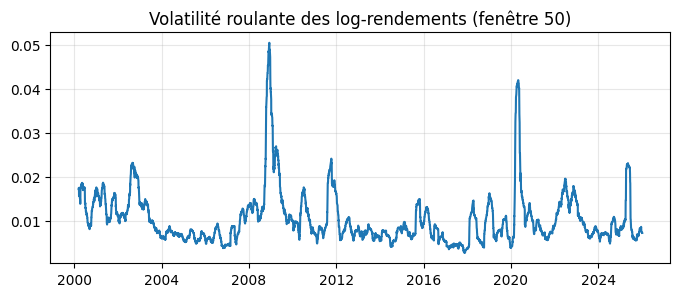

In [ ]:
roll_vol = data["log_ret"].rolling(window=50).std()

plt.figure(figsize=(8,3))
plt.plot(roll_vol)
plt.title("Volatilité roulante des log-rendements (fenêtre 50)")
plt.grid(True, alpha=0.3)
plt.show()



La volatilité roulante des log-rendements
présente une **forte hétéroscédasticité** :

- des périodes de volatilité faible et relativement stable,
- alternant avec des épisodes de volatilité très élevée.

- un HMM à 2 ou 3 états permet de modéliser des régimes de **faible volatilité**
  (marché calme / bull) et des régimes de **forte volatilité**
  (crises, marchés bear),
- chaque régime possède sa propre variance, ce qui donne une description plus
  réaliste de la dynamique des rendements que le modèle gaussien normal.

## 2. Estimation d'un HMM gaussien (in-sample)

Le modèle HMM estime, à partir des log-rendements :

- la **matrice de transition** \(A\) entre régimes,
- la **moyenne** et la **variance** des rendements dans chaque régime.

L’estimation se fait par maximisation de la vraisemblance (algorithme EM).

Les hypothèses implicites ici sont :

- les **log-rendements** sont donc (en première approximation) des réalisations d’une loi
  normale conditionnelle au régime,
- conditionnellement à un régime donné (Bull ou Bear), les rendements successifs sont
  **indépendants et gaussiens**.

L’objectif de la suite de la section est :

- de vérifier que la matrice de transition raconte une histoire **économiquement plausible**,
- de regarder si les régimes sont **persistants** comme on l’attend en finance,
- et de vérifier que, vu sous l’angle du HMM, les statistiques globales des rendements
  (moyenne, variance) restent cohérentes avec ce que l’on observe dans les données.


In [ ]:
n_states = 2

# Reshape des rendements pour hmmlearn (attend un array 2D)
X = data["log_ret"].values.reshape(-1, 1)

hmm_full = GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=200,
    random_state=42
)
hmm_full.fit(X)

# Matrice de transition
A = hmm_full.transmat_
means = hmm_full.means_.flatten()
vars_ = np.array([np.diag(cov)[0] for cov in hmm_full.covars_])
stds = np.sqrt(vars_)

A, means, stds

(array([[0.98933378, 0.01066622],
        [0.02791458, 0.97208542]]),
 array([ 0.00087509, -0.00114575]),
 array([0.00729672, 0.02009071]))

### 2.1. Matrice de transition et propriétés




La matrice de transition \(A\) vérifie :

- $a_{ij} \ge 0$ pour tous \(i,j\),
- chaque **ligne** somme à 1 (probabilités conditionnelles).

Les éléments diagonaux $a_{ii}$ mesurent la
**persistance** du régime \(i\) : plus $a_{ii}$ est proche de 1, plus le modèle
estime que, une fois entré dans ce régime, le marché a tendance à y rester.

On réordonne les états par moyenne de rendement croissante et on les étiquette :

- **Bear** : régime à moyenne de rendement plus faible
- **Bull** : régime à moyenne de rendement plus élevée



In [ ]:
# Ordonner les états par moyenne croissante
order = np.argsort(means)
means_ord = means[order]
stds_ord = stds[order]
A_ord = A[order][:, order]

regime_names = ["Bear", "Bull"]  # état 0 = bear, état 1 = bull

print("Matrice de transition (ordonnée Bear/Bull) :")
print(pd.DataFrame(
    A_ord,
    index=regime_names,
    columns=regime_names
))

print("\nMoyennes journalières par régime (ordonnés) :")
for i, name in enumerate(regime_names):
    print(f"{name}: mean={means_ord[i]:.6f}, std={stds_ord[i]:.6f}")

# Durée moyenne de séjour
durations = 1 / (1 - np.diag(A_ord))
print("\nDurée moyenne de séjour (en jours de bourse) :")
for i, name in enumerate(regime_names):
    print(f"{name}: {durations[i]:.2f} jours")

Matrice de transition (ordonnée Bear/Bull) :
          Bear      Bull
Bear  0.972085  0.027915
Bull  0.010666  0.989334

Moyennes journalières par régime (ordonnés) :
Bear: mean=-0.001146, std=0.020091
Bull: mean=0.000875, std=0.007297

Durée moyenne de séjour (en jours de bourse) :
Bear: 35.82 jours
Bull: 93.75 jours


Dans notre exemple (matrice ordonnée Bear/Bull), on obtient par exemple :

- $A_{Bear,Bear} \approx 0.97$ : un régime Bear a ~97 % de chance de rester Bear
  d’un jour au lendemain,
- $A_{Bull,Bull} \approx 0.99$ : un régime Bull est encore plus persistant,
- les probabilités de changement de régime $A_{Bear,Bull}$ et $A_{Bull,Bear}$
  sont faibles, ce qui correspond à l’idée de **phases de marché longues**,
  séparées par des transitions relativement rares.

La **durée moyenne de séjour** dans le régime $i$ est approximativement :

$
\mathbb{E}[T_i] \approx \frac{1}{1 - a_{ii}}.
$

On obtient ainsi (en jours de bourse) :

- Bear : ~35 jours,
- Bull : ~94 jours.

Ces durées et ces probabilités de transition sont cohérentes avec l’intuition
financière : le marché passe plus de temps en régime haussier et les phases de crise
sont plus courtes mais plus volatiles.  
Cette étape sert à vérifier que le HMM ne produit pas des régimes artificiels
ou trop instables (par exemple des $a_{ii}$ très faibles).


 ### 2.2. Distribution stationnaire des régimes


##### Calcul de distribution stationnaire des régimes

La **distribution stationnaire** d’une chaîne de Markov est un vecteur de
probabilités $\pi = (\pi_1, \dots, \pi_N)$ tel que :

$
\pi^\top A = \pi^\top, \qquad \sum_{i=1}^N \pi_i = 1.
$


- $\pi_i$ représente la **fraction de temps à long terme** passée dans le régime \(i\),
- dans notre HMM, $\pi_{Bear}$ et $\pi_{Bull}$ indiquent combien de temps le marché
  est censé être en régime baissier ou haussier sur le très long terme.



In [ ]:

# Calcul de la distribution stationnaire (via vecteur propre associé à la valeur propre 1)
eigvals, eigvecs = np.linalg.eig(A_ord.T)
# vecteur propre associé à la valeur propre la plus proche de 1
idx = np.argmin(np.abs(eigvals - 1))
pi = np.real(eigvecs[:, idx])
pi /= pi.sum()

print("Distribution stationnaire (Bear, Bull) :")
for i, name in enumerate(regime_names):
    print(f"{name}: {pi[i]:.3f}")


Distribution stationnaire (Bear, Bull) :
Bear: 0.276
Bull: 0.724


À long terme, le marché passe environ 27,7 % du temps en Bear et 72,3 % du temps en Bull
À partir de la matrice de transition estimée, on trouve par exemple :


Cette distribution stationnaire est importante pour la suite :

- elle sert de **poids de mélange** des régimes pour reconstruire les statistiques
  globales des rendements (moyenne / variance inconditionnelles),
- elle permet de vérifier que le HMM ne raconte pas une histoire “absurde”
  (par exemple un marché qui passerait 80 % du temps en Bear).

##### Moyenne et variance globales des log-rendements (vue HMM)

Le HMM fournit pour chaque régime $k$ :

- une probabilité stationnaire $\pi_k$,
- une moyenne conditionnelle $\mu_k$,
- une variance conditionnelle $\sigma_k^2$.

On peut alors reconstituer les **statistiques globales** des log-rendements :

- Moyenne inconditionnelle :
  $$
  \mathbb{E}[r_t]_{\text{HMM}} = \sum_{k} \pi_k \, \mu_k.
  $$

- Variance inconditionnelle :
  $$
  \mathrm{Var}(r_t)_{\text{HMM}}
  = \sum_{k} \pi_k \left(\sigma_k^2 + \mu_k^2\right)
    - \left(\sum_{k} \pi_k \mu_k\right)^2.
  $$


- L'objectif est de comparer ces valeurs à la moyenne et à la variance **empiriques** des données
  permet de vérifier si le HMM reproduit bien le comportement global du marché.


In [ ]:

# Moyenne empirique des log-rendements
empirical_mean = data["log_ret"].mean()

# Moyenne implicite du HMM (Bear/Bull)
hmm_mean = np.sum(pi * means_ord)   # pi[0]*mu_Bear + pi[1]*mu_Bull

print("Moyenne empirique des log-rendements :")
print(f"{empirical_mean:.8f}")

print("\nMoyenne implicite du HMM (stationnaire) :")
for name, pik, muk in zip(regime_names, pi, means_ord):
    print(f"{name}: pi = {pik:.3f}, mu = {muk:.8f}")
print(f"\nE[r]_HMM = sum(pi_k * mu_k) = {hmm_mean:.8f}")

# Différence
diff = empirical_mean - hmm_mean
print(f"\nDifférence (empirique - HMM) : {diff:.2e}")


Moyenne empirique des log-rendements :
0.00030854

Moyenne implicite du HMM (stationnaire) :
Bear: pi = 0.276, mu = -0.00114575
Bull: pi = 0.724, mu = 0.00087509

E[r]_HMM = sum(pi_k * mu_k) = 0.00031640

Différence (empirique - HMM) : -7.86e-06


In [ ]:

sig2 = stds_ord**2

hmm_var = np.sum(pi * (sig2 + means_ord**2)) - hmm_mean**2
hmm_std = np.sqrt(hmm_var)

empirical_std = data["log_ret"].std()

print("Volatilité empirique (std) des log-rendements :")
print(f"{empirical_std:.8f}")

print("\nVolatilité implicite du HMM (std) :")
print(f"{hmm_std:.8f}")

diff_std = empirical_std - hmm_std
print(f"\nDifférence (empirique - HMM) : {diff_std:.2e}")


Volatilité empirique (std) des log-rendements :
0.01221745

Volatilité implicite du HMM (std) :
0.01228538

Différence (empirique - HMM) : -6.79e-05


Ces écarts très faibles montrent que le HMM **reproduit correctement les deux
premiers moments** (moyenne et variance) de la série de rendements.  



---


   Le HMM est capable de reconstruire le comportement global du marché
en combinant les régimes Bear et Bull, ce qui valide partiellement ses hypothèses
  de gaussien conditionnel et de dynamique de Markov.

 ## 3. Régimes cachés et statistiques conditionnelles



On récupère maintenant :
- la séquence d'états les plus probables (algorithme de Viterbi),
 - la probabilité a posteriori d'être dans chaque régime à chaque date.

On peut alors :
- attribuer chaque jour à un régime,
 - calculer les statistiques des rendements conditionnellement à ce régime.

In [ ]:

# Séquence d'états (non ordonnée)
hidden_states = hmm_full.predict(X)

# Réordonnons les états (mapping ancien -> nouveau)
state_map = {old: new for new, old in enumerate(order)}
hidden_states_ord = np.array([state_map[s] for s in hidden_states])

data["state"] = hidden_states_ord

# Posterior probabilities (gamma_t(i))
posterior_probs = hmm_full.predict_proba(X)
posterior_probs_ord = posterior_probs[:, order]  # réordonner les colonnes

for i, name in enumerate(regime_names):
    data[f"p_{name}"] = posterior_probs_ord[:, i]

data.head()


Price,price,log_ret,state,p_Bear,p_Bull
Ticker,SPY,,,,
Date,,,,,
2000-01-04,88.034294,-0.039891,0,1.000000,1.610801e-133
2000-01-05,88.191750,0.001787,0,0.998922,1.077525e-03
2000-01-06,86.774376,-0.016202,0,0.999717,2.826856e-04
2000-01-07,91.813904,0.056452,0,1.000000,4.841485e-13
2000-01-10,92.128891,0.003425,0,0.994436,5.564290e-03



 ### 3.1. Statistiques descriptives par régime




On découpe maintenant la série de log-rendements en deux sous-échantillons :

- jours classés en **régime Bear**,
- jours classés en **régime Bull**,

puis on calcule pour chaque régime :

- la **moyenne** des rendements,
- la **volatilité** (écart-type),
- le **Sharpe annualisé**,
- la **skewness** et la **kurtosis**.



In [ ]:

regime_stats = []

trading_days = 252

for i, name in enumerate(regime_names):
    r = data.loc[data["state"] == i, "log_ret"]
    mean_d = r.mean()
    vol_d = r.std()
    sharpe = np.sqrt(trading_days) * mean_d / vol_d if vol_d > 0 else np.nan
    skew = r.skew()
    kurt = r.kurtosis()
    regime_stats.append(
        [name, len(r), mean_d, vol_d, sharpe, skew, kurt]
    )

regime_stats_df = pd.DataFrame(
    regime_stats,
    columns=["Regime", "N_obs", "Mean_d", "Std_d", "Sharpe_ann", "Skew", "Kurtosis"]
)
regime_stats_df


,Regime,N_obs,Mean_d,Std_d,Sharpe_ann,Skew,Kurtosis
0,Bear,1795,-0.001145,0.020076,-0.905459,0.046670,4.093942
1,Bull,4747,0.000858,0.007230,1.884376,-0.237279,0.939050



Ces statistiques confirment que le HMM a bien identifié deux régimes
**économiquement interprétables** :

- le régime Bear est associé à des rendements moyens négatifs et à une volatilité
  nettement plus élevée, avec des queues plus épaisses,
- le régime Bull présente des rendements positifs en moyenne, avec une volatilité
  plus faible et une distribution plus proche de la normale.

Impact sur le modèle :

- le fait que les moments (moyenne, variance) soient très différents d’un régime
  à l’autre permet de capturer des
  **comportements conditionnels distincts** ; (confirmer statistiquement la différence dans la partie suivante 3.2)
- la kurtosis reste supérieure à 3 en Bear, ce qui montre que même
  conditionnellement au régime, la loi n’est pas parfaitement gaussienne.(vérification dans la partie 3.3)

### 3.2 Comparaison statistique entre régimes

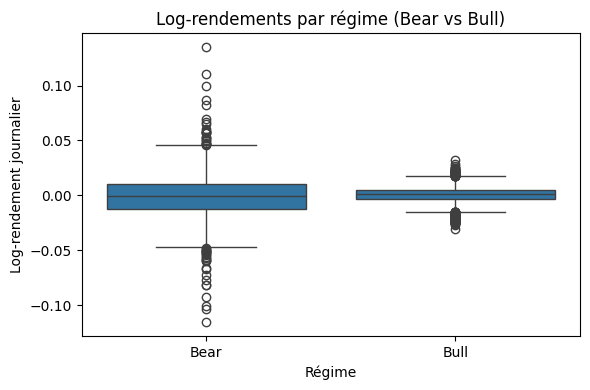

N Bear = 1795, N Bull = 4747

Test de Welch pour la différence de moyenne (log-rendements) :
t-stat = -4.128, p-value = 3.816e-05

Test de Levene pour l'égalité des variances :
stat = 1740.257, p-value = 0.000e+00


In [ ]:


import seaborn as sns

# Créer un label lisible pour les régimes
data["regime_label"] = data["state"].map({0: "Bear", 1: "Bull"})

# --- Boxplot ---
plt.figure(figsize=(6, 4))
sns.boxplot(x="regime_label", y="log_ret", data=data)
plt.title("Log-rendements par régime (Bear vs Bull)")
plt.xlabel("Régime")
plt.ylabel("Log-rendement journalier")
plt.tight_layout()
plt.show()

# --- Extraction des séries par régime ---
bear = data.loc[data["state"] == 0, "log_ret"]
bull = data.loc[data["state"] == 1, "log_ret"]

print(f"N Bear = {len(bear)}, N Bull = {len(bull)}")

# --- Test de différence de moyenne (Welch t-test, variances inégales) ---
t_stat, p_val = stats.ttest_ind(bear, bull, equal_var=False)

print("\nTest de Welch pour la différence de moyenne (log-rendements) :")
print(f"t-stat = {t_stat:.3f}, p-value = {p_val:.3e}")

# --- Test de différence de variance (Levene) ---
lev_stat, lev_p = stats.levene(bear, bull, center="mean")

print("\nTest de Levene pour l'égalité des variances :")
print(f"stat = {lev_stat:.3f}, p-value = {lev_p:.3e}")


Les boxplots et les tests de Welch/Levene confirment que les log-rendements en régime Bear et Bull diffèrent significativement, tant en moyenne qu’en volatilité. Le régime Bear est associé à des rendements moyens négatifs et une volatilité fortement accrue, tandis que le régime Bull présente des rendements positifs et une volatilité plus faible.

### 3.3 Normalité conditionnelle des rendements par régime



 Le modèle GaussianHMM **suppose** que, conditionnellement à un régime donné,
 les rendements suivent une loi normale.

 On peut tester cette hypothèse empiriquement en appliquant des tests
 de normalité sur les rendements classés par régime :
 - Test de Jarque-Bera (sensibilité à skewness et kurtosis),
 - Test de Shapiro-Wilk.

 On peut aussi tracer des QQ-plots.


In [ ]:

from scipy import stats
def normality_tests_by_regime(df, regime_col="state", ret_col="log_ret"):
    rows = []
    for i, name in enumerate(regime_names):
        r = df.loc[df[regime_col] == i, ret_col]
        jb_stat, jb_p = stats.jarque_bera(r)
        sw_stat, sw_p = stats.shapiro(r.sample(min(len(r), 5000), random_state=42))  # Shapiro limité
        rows.append([name, len(r), jb_stat, jb_p, sw_stat, sw_p])
    return pd.DataFrame(
        rows,
        columns=["Regime", "N_obs", "JB_stat", "JB_pval", "SW_stat", "SW_pval"]
    )

normality_df = normality_tests_by_regime(data)
normality_df


,Regime,N_obs,JB_stat,JB_pval,SW_stat,SW_pval
0,Bear,1795,1245.178054,4.102240e-271,0.963593,7.668785e-21
1,Bull,4747,218.095200,4.377530e-48,0.988801,5.806633e-19


Les résultats numériques sont les suivants :

- les statistiques de Jarque–Bera sont très élevées, avec des p-values
  pratiquement nulles, pour **Bear** comme pour **Bull** ;
- les tests de Shapiro–Wilk rejettent eux aussi la normalité.

Conclusion statistique stricte : **même conditionnellement au régime,
l’hypothèse de normalité est rejetée** au sens des tests JB et Shapiro.


 #### QQ-plots par régime

 Les QQ-plots comparent les quantiles empiriques des rendements
 aux quantiles théoriques d'une loi normale. Des écarts systématiques
 indiquent des queues plus épaisses ou des asymétries.



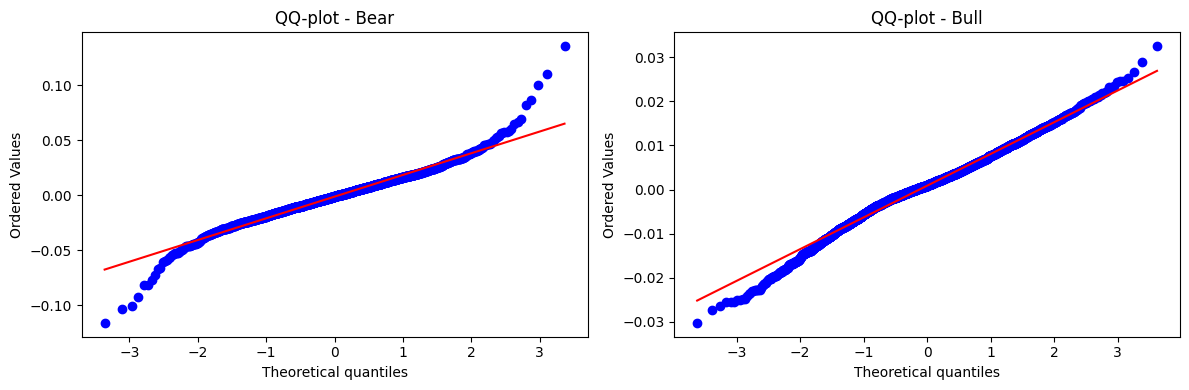

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(regime_names):
    r = data.loc[data["state"] == i, "log_ret"]
    ax = axes[i]
    stats.probplot(r, dist="norm", plot=ax)
    ax.set_title(f"QQ-plot - {name}")

plt.tight_layout()
plt.show()


- D’un point de vue **théorique**, l’hypothèse $ r_t \mid S_t = k \sim \mathcal{N}(\mu_k,\sigma_k^2) $
  est **formellement violée** : les tests de normalité rejettent la gaussienne
  conditionnelle dans les deux régimes.
- D’un point de vue **pratique**, la gaussienne reste une **bonne première approximation**
  pour la majeure partie des observations, mais elle sous-estime la probabilité
  des mouvements extrêmes, surtout en Bear.

### 3.4 Visualisation des régimes





On représente les prix de SPY en colorant les périodes en fonction du régime
le plus probable (séquence de Viterbi).

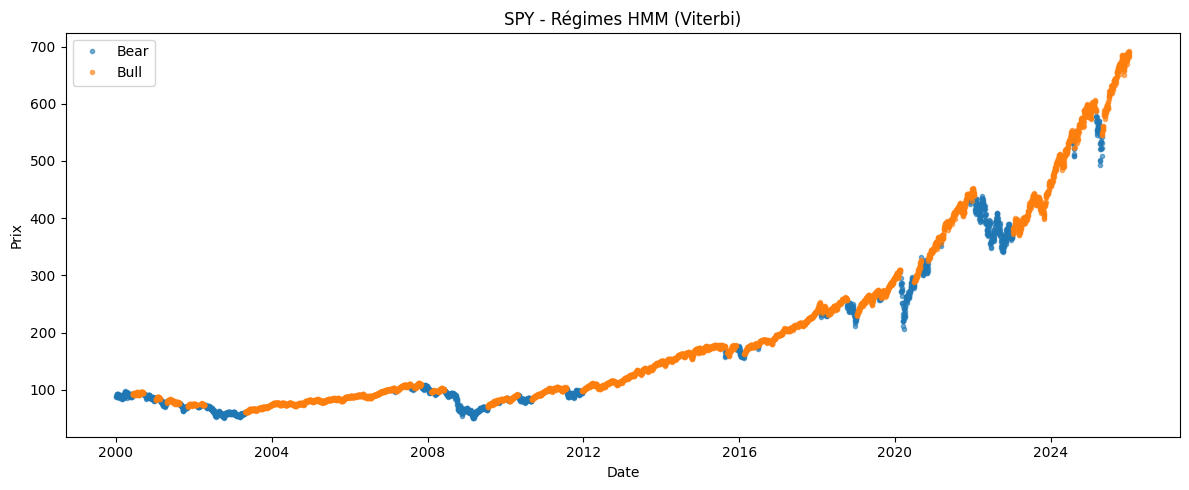

In [ ]:

plt.figure(figsize=(12, 5))
for i, name in enumerate(regime_names):
    mask = data["state"] == i
    plt.plot(data.index[mask], data["price"][mask], ".", label=name, alpha=0.6)

plt.title("SPY - Régimes HMM (Viterbi)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.tight_layout()
plt.show()


Cette visualisation permet de vérifier qualitativement que :

- les périodes classées en **Bear** se concentrent autour des grandes crises
  (éclatement de la bulle internet, crise financière de 2008, choc COVID, etc.),
- les phases au long cours de hausse relativement régulière sont classées en
  **Bull**,
- les régimes sont **persistants dans le temps** : on observe de longs segments
  de même couleur plutôt qu’une alternance chaotique jour par jour.

## 5. Signaux de trading pour SPY

Après avoir vérifié que le HMM identifie bien deux régimes de marché distincts
(Bear / Bull), on construit une **stratégie de trading** qui exploite
cette information.


- utiliser les **probabilités a posteriori** $P(S_t = \text{Bull} \mid \text{données})$
  et $P(S_t = \text{Bear} \mid \text{données})$,
- définir une règle de décision qui transforme ces probabilités en **position
  de portefeuille** (long / short / partiellement investi),
- backtester la stratégie sur toute la période et la comparer à une stratégie
  de **Buy & Hold** sur le SPY.

#### Fonctions pour plot

In [ ]:
import plotly.graph_objects as go

def plot_signals_with_regimes(
    dates,
    price,
    signal,
    proba_bull,
    proba_bear,
    threshold=0.7,
    title="Signaux de trading et régimes HMM"
):
    """
    Graphique interactif Plotly :
      - courbe de prix
      - triangles de signaux (vert ^ si signal>0, rouge v si signal<0)
      - fond coloré selon le régime :
          vert = bullish (P(Bull) > threshold)
          rouge = bearish (P(Bear) > threshold)
          gris = neutre (aucun seuil atteint)
    """

    dates = np.asarray(dates)
    price = np.asarray(price)
    signal = np.asarray(signal)
    proba_bull = np.asarray(proba_bull)
    proba_bear = np.asarray(proba_bear)

    assert len(dates) == len(price) == len(signal) == len(proba_bull) == len(proba_bear)

    # 1) Régime à chaque date : +1 = Bull, -1 = Bear, 0 = neutre
    regime = np.zeros(len(dates), dtype=int)
    regime[proba_bull > threshold] = 1
    regime[proba_bear > threshold] = -1

    # 2) Figure Plotly
    fig = go.Figure()

    # Courbe de prix
    fig.add_trace(
        go.Scatter(
            x=dates,
            y=price,
            mode="lines",
            name="Prix",
            line=dict(width=1.5, color="black"),
        )
    )

    # 3) Zones de background par segment de régimes
    shapes = []

    def regime_color(reg):
        if reg == 1:
            return "rgba(0, 200, 0, 0.12)"
        elif reg == -1:
            return "rgba(200, 0, 0, 0.12)"
        else:
            return "rgba(150, 150, 150, 0.10)"

    current_regime = regime[0]
    start_idx = 0

    for t in range(1, len(regime)):
        if regime[t] != current_regime:
            shapes.append(
                dict(
                    type="rect",
                    xref="x",
                    yref="paper",
                    x0=dates[start_idx],
                    x1=dates[t-1],
                    y0=0,
                    y1=1,
                    fillcolor=regime_color(current_regime),
                    line=dict(width=0),
                    layer="below",
                )
            )
            current_regime = regime[t]
            start_idx = t

    # Dernier segment
    shapes.append(
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=dates[start_idx],
            x1=dates[-1],
            y0=0,
            y1=1,
            fillcolor=regime_color(current_regime),
            line=dict(width=0),
            layer="below",
        )
    )

    # 4) Triangles pour les signaux
    signal_prev = np.concatenate([[0], signal[:-1]])
    delta = signal - signal_prev
    buy_idx = np.where(delta > 0)[0]
    sell_idx = np.where(delta < 0)[0]

    # Achats : triangle vert vers le haut
    if len(buy_idx) > 0:
        fig.add_trace(
            go.Scatter(
                x=dates[buy_idx],
                y=price[buy_idx],
                mode="markers",
                name="Signal achat (>0)",
                marker=dict(
                    symbol="triangle-up",
                    size=11,
                    color="green",
                    line=dict(color="black", width=1),
                ),
            )
        )

    # Ventes : triangle rouge vers le bas
    if len(sell_idx) > 0:
        fig.add_trace(
            go.Scatter(
                x=dates[sell_idx],
                y=price[sell_idx],
                mode="markers",
                name="Signal vente (<0)",
                marker=dict(
                    symbol="triangle-down",
                    size=11,
                    color="red",
                    line=dict(color="black", width=1),
                ),
            )
        )

    # 5) Layout
    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Prix",
        shapes=shapes,
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    )

    fig.show()


In [ ]:


def plot_positions_plotly(dates, signal, title="Positions au fil du temps"):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=dates,
            y=signal,
            mode="lines",
            name="Position",
        )
    )

    fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey")

    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Position",
        hovermode="x unified",
    )

    fig.show()
def analyze_strategy_plotly(
    returns,          # pd.Series de log-rendements du sous-jacent
    price,            # pd.Series de prix (même index que returns)
    signal,           # pd.Series ou array de positions (-1,0,1, ou levier)
    freq=252,
    window_rolling=20,
    title="Analyse de la stratégie"
):
    """
    Analyse une stratégie :
      - equity courbe vs buy & hold
      - drawdown
      - vol / Sharpe mobiles
      - exposition moyenne
    Et affiche tout dans un graphique Plotly interactif.
    """

    # ----------------------------
    # 0) Alignement & DataFrame
    # ----------------------------
    df = pd.DataFrame({
        "return": returns,
        "price": price,
        "signal": signal
    }).dropna()

    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # 1) Rendements stratégie (position t-1 * r_t)
    # ----------------------------
    df["signal_shifted"] = df["signal"].shift(1).fillna(0)
    df["ret_strat"] = df["signal_shifted"] * df["return"]

    # Benchmark = buy & hold sur le sous-jacent
    df["ret_bench"] = df["return"]

    # ----------------------------
    # 2) Equity curves (base 100)
    # ----------------------------
    df["equity_strat"] = 100 * np.exp(df["ret_strat"].cumsum())
    df["equity_bench"] = 100 * np.exp(df["ret_bench"].cumsum())

    # ----------------------------
    # 3) Drawdowns
    # ----------------------------
    def drawdown(equity):
        peak = equity.cummax()
        dd = equity / peak - 1.0
        return dd

    df["dd_strat"] = drawdown(df["equity_strat"])
    df["dd_bench"] = drawdown(df["equity_bench"])

    # ----------------------------
    # 4) Vol & Sharpe mobiles
    # ----------------------------
    roll_ret = df["ret_strat"].rolling(window_rolling)

    df["roll_vol"] = roll_ret.std() * np.sqrt(freq)
    df["roll_mean"] = roll_ret.mean() * freq
    df["roll_sharpe"] = df["roll_mean"] / df["roll_vol"]

    # ----------------------------
    # 5) Exposition moyenne (absolue)
    # ----------------------------
    df["roll_expo"] = df["signal"].abs().rolling(window_rolling).mean()

    # ----------------------------
    # 6) Stats globales
    # ----------------------------
    mu_annual = df["ret_strat"].mean() * freq
    vol_annual = df["ret_strat"].std() * np.sqrt(freq)
    sharpe = mu_annual / vol_annual if vol_annual > 0 else np.nan
    mdd = df["dd_strat"].min()
    # Benchmark (Buy & Hold)
    mu_b  = df["ret_bench"].mean() * freq
    vol_b = df["ret_bench"].std()  * np.sqrt(freq)
    sh_b  = mu_b / vol_b if vol_b > 0 else np.nan
    mdd_b = df["dd_bench"].min()

    print(f"STRAT | CAGR ≈ {mu_annual:.2%} | Vol ≈ {vol_annual:.2%} | Sharpe ≈ {sharpe:.2f} | Max DD ≈ {mdd:.2%}")
    print(
        f"BENCH  | CAGR ≈ {mu_b:.2%} | Vol ≈ {vol_b:.2%} | Sharpe ≈ {sh_b:.2f} | Max DD ≈ {mdd_b:.2%}"
         )
    # ----------------------------
    # 7) Plotly : 4 sous-graphiques
    # ----------------------------
    fig = make_subplots(
        rows=4, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.35, 0.20, 0.22, 0.23],
        subplot_titles=(
            "Equity curve (stratégie vs Buy & Hold)",
            "Drawdown",
            f"Vol  ({window_rolling} j)",
            f"Exposition moyenne |signal| ({window_rolling} j)"
        )
    )

    x = df.index

    # 1) Equity
    fig.add_trace(
        go.Scatter(x=x, y=df["equity_bench"], name="Buy & Hold", line=dict(width=1, dash="dot")),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=x, y=df["equity_strat"], name="Stratégie", line=dict(width=1.5)),
        row=1, col=1
    )

    # 2) Drawdown
    fig.add_trace(
        go.Scatter(x=x, y=df["dd_bench"], name="DD Buy & Hold", line=dict(width=1, dash="dot")),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=x, y=df["dd_strat"], name="DD Stratégie", line=dict(width=1.2)),
        row=2, col=1
    )

    # 3) Vol mobile
    fig.add_trace(
        go.Scatter(x=x, y=df["roll_vol"], name="Vol mobile (strat)", line=dict(width=1.2)),
        row=3, col=1
    )
    """fig.add_trace(
        go.Scatter(x=x, y=df["roll_sharpe"], name="Sharpe mobile (strat)", line=dict(width=1.2)),
        row=3, col=1
    )"""

    # 4) Exposition moyenne
    fig.add_trace(
        go.Scatter(x=x, y=df["roll_expo"], name="|signal| moyen", line=dict(width=1.2)),
        row=4, col=1
    )

    fig.update_yaxes(title_text="Equity", row=1, col=1)
    fig.update_yaxes(title_text="Drawdown", row=2, col=1)
    fig.update_yaxes(title_text="Vol / Sharpe", row=3, col=1)
    fig.update_yaxes(title_text="Expo", row=4, col=1)

    fig.update_layout(
        title=title,
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
        xaxis4=dict(title="Date")
    )

    fig.show()

    return df


#### Règles de décision


On fixe deux seuils :

- `high = 0.7` : probabilité **forte**,
- `low = 0.55` (éventuellement exploitable pour une version plus graduelle).

La règle utilisée est la suivante :

- si $p_t^{Bull} > 0.7$ : on prend une **position longue** (signal = +1),
- si $p_t^{Bear} > 0.7$ : on prend une **position courte** (signal = −1)  
  ou bien on sort du marché selon la variante choisie,
- si aucune probabilité n’est très dominante (zone d’incertitude), on adopte
  une **exposition réduite** (par exemple 0 ou 0.5).

In [ ]:
threshold = 0.7

# Probas sous forme de Series bien alignées
proba_bull_s = pd.Series(data["p_Bull"], index=data.index)
proba_bear_s = pd.Series(data["p_Bear"], index=data.index)



high = 0.7   # fort
low  = 0.55  # faible

signal_simple = np.zeros_like(proba_bull_s, dtype=float)

# Bull fort
signal_simple[proba_bull_s > high] = 1.0

# Bear fort
signal_simple[proba_bear_s > high] = -1.0

# On force à 0 (incertain) si aucune proba n'est très forte
mask_uncertain = (proba_bull_s < high) & (proba_bear_s < high)
signal_simple[mask_uncertain] = 0.5

signal_simple = pd.Series(signal_simple, index=data.index)

####  Backtest de la stratéegie

`perf_stats` calcule, à partir d’une série de rendements de stratégie :

   - le **rendement annualisé**,
   - la **volatilité annualisée**,
   - le **ratio de Sharpe** (sans taux sans risque, pour simplifier).

   Les rendements journaliers sont annualisés en multipliant la moyenne par 252
   (nombre approximatif de jours de bourse) et l’écart-type par $\sqrt{252}$.

In [ ]:
def perf_stats(strat_ret, freq=252):
    mu = np.mean(strat_ret) * freq
    sigma = np.std(strat_ret) * np.sqrt(freq)
    sharpe = mu / sigma if sigma > 0 else np.nan
    return mu, sigma, sharpe

 `backtest_from_signal` applique une série de **signaux de position**
   à la série de log-rendements :

   - les rendements journaliers du SPY sont notés $r_t$,
   - la position $s_t$ (−1, 0, 0.5, 1, …) est appliquée **au rendement du jour t+1**,
     ce qui garantit un backtest **causal** (pas de look-ahead biais),
   - on en déduit :

     - les rendements de la stratégie : $r_t^{\text{strat}} = s_t \, r_{t+1}$,
     - la trajectoire de capital de la stratégie,
     - la trajectoire de capital d’un **Buy & Hold** sur le SPY pour comparaison.

In [ ]:
def backtest_from_signal(returns, signal, initial_capital=100.0):

    r = np.asarray(returns)
    s = np.asarray(signal)

    strat_ret = s[:-1] * r[1:]                       # log-rendements stratégie
    equity = initial_capital * np.exp(np.cumsum(strat_ret))
    bh = initial_capital * np.exp(np.cumsum(r[1:]))

    return strat_ret, equity, bh


In [ ]:

# Backtest
strat_ret_S, equity_S, bh_S = backtest_from_signal(data["log_ret"], signal_simple)

muS, sigS, shS = perf_stats(strat_ret_S)
dates_eff = data.index[1:]


#### Résultats du backtest

In [ ]:
df_plot = pd.DataFrame({
    "price": data["price"].squeeze(),
    "signal": signal_simple,
    "proba_bull": data["p_Bull"].values,
    "proba_bear": data["p_Bear"].values,
}, index=data["price"].index)

plot_signals_with_regimes(
    dates=df_plot.index,
    price=df_plot["price"],
    signal=df_plot["signal"],
    proba_bull=df_plot["proba_bull"],
    proba_bear=df_plot["proba_bear"],
    threshold=0.7,
    title="SPY – Signaux HMM + background de régimes"
)

In [ ]:
plot_positions_plotly(data["price"].index, signal_simple)


In [ ]:
df_indic = analyze_strategy_plotly(
    returns=data["log_ret"],
    price=data["price"].squeeze(),      # ou prices_spy
    signal=signal_simple,     # ou position_C etc.
    freq=252,
    window_rolling=63,
    title="Analyse stratégie HMM (simple)"
)


STRAT | CAGR ≈ 19.28% | Vol ≈ 18.93% | Sharpe ≈ 1.02 | Max DD ≈ -29.75%
BENCH  | CAGR ≈ 7.78% | Vol ≈ 19.39% | Sharpe ≈ 0.40 | Max DD ≈ -55.19%



- ces résultats sont **in-sample** (le modèle est estimé sur toute la période),
- la performance hors échantillon sera plus faible,
- la stratégie ne tient pas compte des **coûts de transaction**, ni des
  contraintes pratiques (leviers, financement, etc.).

La prochaine étape consisterait à mettre en place un **backtest rolling**
(ré-estimation du HMM sur une fenêtre glissante) d'une stratégie plus réaliste